   Copyright 2015-2023, University of Bern, Laboratory for High Energy Physics and Theodor Kocher Institute, M. Vladymyrov

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.


In [4]:
#imports
import time

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipyd
import copy
import os
import shutil
import numpy as np
import tensorflow as tf
from utils import net_utils as nu
from tensorflow.python.client import timeline

from utils import imgio as iio
from utils import dataset as ds
from utils.histnorm import NormHist
import json
import pickle

from skimage.morphology import binary_dilation
from scipy.interpolate import interp1d as interp
from scipy.ndimage import distance_transform_edt

from PIL import Image

## Prepare centroids

In [ ]:
# cntr label and cells segmentation processing function generating mask for training

# read cell label data
def get_cell_centroids_xy(path_dir, min_centr_val=10):
    path_cell_inf = os.path.join(path_dir, 'cells_info.dat')
    path_cell_dat = os.path.join(path_dir, 'cells.dat')
    #1. header
    with open(path_cell_inf, 'rt') as f:
        column_names_str = f.readline()

    column_names = column_names_str.split()
    name_idx_map = {name:idx for idx, name in enumerate(column_names)}

    #2. data
    cell_data = np.fromfile(path_cell_dat, sep=' ')
    cell_data = cell_data.reshape((-1, len(column_names)))

    # extract x, y, npix, centr_mean
    all_timeframes = cell_data[:, name_idx_map['timeframe']]
    all_x = cell_data[:, name_idx_map['x']]
    all_y = cell_data[:, name_idx_map['y']]
    all_npix = cell_data[:, name_idx_map['npix']]
    all_cntrm = cell_data[:, name_idx_map['centr_mean']]

    all_cntr = all_npix * all_cntrm

    #select values
    ok_idx = all_cntr < min_centr_val

    all_timeframes = all_timeframes [ok_idx]
    all_x          = all_x          [ok_idx]
    all_y          = all_y          [ok_idx]
    all_npix       = all_npix       [ok_idx]
    all_cntrm      = all_cntrm      [ok_idx]

    # split by timeframe, save x, y
    all_timeframes_set = set(all_timeframes)

    centroids_coords = {}  # centroids_coords[tf_idx] = list([x,y])

    for tf in all_timeframes_set:
        tf_idx = all_timeframes==tf

        xs = all_x[tf_idx]
        ys = all_y[tf_idx]

        xy_arr = centroids_coords[int(tf)] = []

        for x, y in zip(xs,ys):
            xy_arr.append([x,y])
            
    return centroids_coords

# read centroid label data
def get_lbl_centroids_xy(path_dir):
    path_cell_inf = os.path.join(path_dir, 'centr_info.dat')
    path_cell_dat = os.path.join(path_dir, 'centr.dat')
    
    #1. header
    with open(path_cell_inf, 'rt') as f:
        column_names_str = f.readline()

    column_names = column_names_str.split()
    name_idx_map = {name:idx for idx, name in enumerate(column_names)}

    #2. data
    cell_data = np.fromfile(path_cell_dat, sep=' ')
    cell_data = cell_data.reshape((-1, len(column_names)))
    
    # split by timeframe, extract x, y, npix, centr_mean
    all_timeframes = cell_data[:, name_idx_map['timeframe']]
    all_x = cell_data[:, name_idx_map['x']]
    all_y = cell_data[:, name_idx_map['y']]

    # split by timeframe, save x, y
    all_timeframes_set = set(all_timeframes)

    centroids_coords = {}  # centroids_coords[tf_idx] = list([x,y])

    for tf in all_timeframes_set:
        tf_idx = all_timeframes==tf

        xs = all_x[tf_idx]
        ys = all_y[tf_idx]

        xy_arr = centroids_coords[int(tf)] = []

        for x, y in zip(xs,ys):
            xy_arr.append([x,y])
            
    return centroids_coords

# merge labeled centroids and single cells segmentation
def merge_centroids(c1, c2):
    c = copy.deepcopy(c1)
    for t2, arr_xy2 in c2.items():
        if t2 in c:
            arr_xy1 = c[t2]
            for x,y in arr_xy2:
                arr_xy1.append([x,y])
        else:
            arr_xy1 = c[t2] = []
            for x,y in arr_xy2:
                arr_xy1.append([x,y])
    
    return c

def get_centr_xyt(centroids_map):
    xs = []
    ys = []
    ts = []
    for t,xyarr in centroids_map.items():
        for x,y in xyarr:
            ts.append(t)
            xs.append(x)
            ys.append(y)
            
    return xs,ys,ts

#example drawing
#plt.figure(figsize=(16,12))
#x,y,t = get_centr_xyt(centroids_coords_cells)
#plt.scatter(x, y, c=t, s=5)
#x,y,t = get_centr_xyt(centroids_coords_label)
#plt.scatter(x, y, c='red', s=5, marker='+')
#plt.show()

#fill distance to neares
def fill_nearest_radius(centroids):
    c2 = {}
    
    for t, arr in centroids.items():
        xyr = c2[t] = []
        
        xy = np.array(arr)
        #print(t, xy.shape)
        
        for x, y in xy:
            dxy = xy - np.array([x,y]).reshape((1, 2))
            dxy *= dxy
            
            dr2 = dxy.sum(axis=1)
            
            dr2 = dr2[dr2>0]
            dr2_min = dr2.min()
            dr = np.sqrt(dr2_min)
            
            #print(dr)
            
            xyr.append([x,y,dr])
            
    return c2

#generate training images
def make_flt_1d(s, ns, a):
    k = int(ns*s)
    if k%2 == 0:
        k += 1
    
    f = [a * np.exp( -(i+0.5-k/2)**2 / 2 / s**2) for i in range(k)]
    return np.array(f)
def make_flt_2d(s, ns, a):
    fxy = make_flt_1d(s, ns, a)
    f = np.matmul(fxy[:, np.newaxis], fxy[np.newaxis,:])/a
    return f
def gen_centroid_masks(s_min, s_max):
    flts = {}
    for s in np.arange(s_min, s_max, 0.15):
        f = make_flt_2d(s, 6, 255).astype(np.int32)
        flts[s] = f
    return flts

def place_mask(x, y, masks, r, arr):
    rs = np.array(list(masks.keys()))
    
    drs = np.abs(rs - r)
     = drs.argmin()
    
    r0 = rs[idx]
    mask = masks[r0]
    
    f_sz = mask.shape[0]
    d = f_sz//2
    h, w = arr.shape[:2]
    
    x = min(w-1, max(0, int(x)))
    y = min(h-1, max(0, int(y)))
    
    a_x0 = x - d
    a_x1 = x + d + 1
    a_y0 = y - d
    a_y1 = y + d + 1

    m_x0 = 0
    m_x1 = f_sz
    m_y0 = 0
    m_y1 = f_sz
    
    if a_x0 < 0:
        m_x0 -= a_x0
        a_x0 = 0
    if a_y0 < 0:
        m_y0 -= a_y0
        a_y0 = 0
    
    if a_x1 > w:
        m_x1 -= (a_x1 - w)
        a_x1 = w
    if a_y1 > h:
        m_y1 -= (a_y1 - h)
        a_y1 = h
    
    #print(a_x0, a_y0, a_x1-a_x0, a_y1-a_y0)
    #print(m_x0, m_y0, m_x1-m_x0, m_y1-m_y0)
    
    a = arr[a_y0:a_y1, a_x0:a_x1]
    m = mask[m_y0:m_y1, m_x0:m_x1]
    #print(a.shape, m.shape, mask.shape)
    
    a += m
    
def draw_centroids(w, h, out_path, name_tmpl, centr_xyr):
    # get size
    masks = gen_centroid_masks(1.5, 5)
    
    for t, xyr in centr_xyr.items():
        im = np.zeros((h, w), dtype=np.int32)
        for x,y,r in xyr:
            # min - 1.5, max - 4
            d = r/10*1
            d = min(4, max(1.5, d))
            #print(r, d)
            place_mask(x, y, masks, d, im) #d = 2.5 
            
        im = im.clip(0, 255).astype(np.uint8)

        path = os.path.join(out_path, name_tmpl % t)
        iio.save_image(im, path)

In [ ]:
masks = gen_centroid_masks(1.5, 5)

In [ ]:
masks[1.5]

In [ ]:
for m in masks.values():
    plt.plot(m[len(m)//2])

In [ ]:
plt.plot(masks[1.5][4])

In [ ]:
# generate

path0 = 'data/data_prep/'

for ds_id in [1, 2, 3, 5]:
    path_dir = os.path.join(path0, '%d'%ds_id, 'centroids_info')
    out_dir = os.path.join(path0, '%d'%ds_id, 'labels')
    
    centroids_coords_cells = get_cell_centroids_xy(path_dir)
    centroids_coords_label = get_lbl_centroids_xy(path_dir)
    centroids_coords_all = merge_centroids(centroids_coords_cells, centroids_coords_label)
    
    xyr_all = fill_nearest_radius(centroids_coords_all)
    im = iio.read_image(os.path.join(out_dir, 'cntr_000.png'))
    h, w = im.shape[:2]
    
    draw_centroids(w, h, out_dir, 'cntr_tgt_%03d.png', xyr_all)

In [ ]:
# fill empty non_ex
for ds_id in [1, 2, 3, 5]:
    out_dir = os.path.join(path0, '%d'%ds_id, 'labels')
    
    im = iio.read_image(os.path.join(out_dir, 'cntr_000.png'))
    h, w = im.shape[:2]
    im = np.zeros((h,w), dtype=np.uint8)
    
    for t in range(180):
        path = os.path.join(out_dir, 'cntr_tgt_%03d.png' % t)
        path_from = ''
        if not os.path.exists(path):
            if len(path_from)==0:
                iio.save_image(im, path)
                path_from = path
            else:
                copyfile(path_from, path)

In [ ]:
# gen test centr mask, overlayed with cell mask over thres
thres = 85
for ds_id in [1, 2, 3, 5]:
    out_dir = os.path.join(path0, '%d'%ds_id, 'labels')
    
    for t in range(180):
        path_c = os.path.join(out_dir, 'cntr_tgt_%03d.png' % t)
        path_m = os.path.join(out_dir, 'lbl_%03d.png' % t)
        path_t = os.path.join(out_dir, 'cntr_tst_%03d.png' % t)
        
        im_c = iio.read_image(path_c)
        im_m = iio.read_image(path_m)
        
        zeroed_idx = im_m <= thres
        im = im_c.copy()
        im[zeroed_idx] = 0
        iio.save_image(im, path_t)        

## Input
As input we take extracted png layers (red) from manually labeled PSD: 'label' - cell mask, 'diap' - diapedeasing coarse mask, 'cntr' - dots in centers of overlapping cells.

We then convert files to gray scale.

In [ ]:
# manually labeled pathes
path1 = 'data/data_prep/1/'
path2 = 'data/data_prep/2/'
path3 = 'data/data_prep/3/'
path5 = 'data/data_prep/5/'
all_man_paths = [path1, path2, path3, path5]

hist_norm_ref_ds = [1,2,3,4,5,6,7,8,9,10]

stacks_names = [path + 'imgs_aligned_all/raw/%03d.png' for path in all_man_paths]  # raw image
pred2d_names = [path + 'imgs_aligned_all/pred_2d/%03d.png' for path in all_man_paths]  # raw image
hn_stk_names_all = [[path + 'imgs_aligned_all/raw_hist_norm_refds_%02d'%rds_id+'/%03d.png' for path in all_man_paths]
                        for rds_id in hist_norm_ref_ds
                   ]# hist-normalized raw image
labels_names = [path + 'imgs_aligned_all/lbl/%03d.png' for path in all_man_paths]  # full cell label
diap_c_names = [path + 'imgs_aligned_all/diap/%03d.png' for path in all_man_paths]  # coarse diapedesis mask
diap_m_names = [path + 'imgs_aligned_all/diap_m/%03d.png' for path in all_man_paths]  # overlap mask
diap_dst_names =     [path + 'imgs_aligned_all/diap_dst/%03d.png' for path in all_man_paths]  # overlap mask
diap_exp_dst_names = [path + 'imgs_aligned_all/diap_exp_dst/%03d.png' for path in all_man_paths]  # overlap mask
cntr_t_names = [path + 'imgs_aligned_all/cntr/%03d.png' for path in all_man_paths]  # label of centers, target for training

# not aligned
stacks_names_na = [path + 'raw_and_mask/r_%03d.png' for path in all_man_paths]  # raw image
labels_names_na = [path + 'labels/lbl_%03d.png' for path in all_man_paths]  # full cell label
diap_c_names_na = [path + 'labels/diap_%03d.png' for path in all_man_paths]  # coarse diapedesis mask
cntr_o_names_na = [path + 'labels/cntr_%03d.png' for path in all_man_paths]  # label of center of the overlapping cells


In [ ]:
#fn = 'BBB/model_BBB_BN_TV_FCN4_SkipC_2018.09.21_09-35/model_info_dict.pkl'
fn = 'BBB/model_BBB_BN_TV_FCN4_SkipC_2018.09.28_18-31/model_info_dict.pkl'
with open(fn, mode='rb') as f:
    d = pickle.load(f)
d

In [ ]:
#convert masks to 8 bit
for sn, ln, dn, cn in zip(stacks_names_na, labels_names_na, diap_c_names_na, cntr_o_names_na):
    for tmpl in [sn, ln, dn, cn]:
        print(tmpl)
        for idx in range(180):
            path = tmpl % idx
            if os.path.exists(path):
                im = np.asarray(Image.open(path))
                if len(im.shape) == 3: # rgb/rgba, non grayscale, to be converted
                    if im.shape[2] == 4:  # rgba -> gs=r*a
                        im = (im[:, :, 3] / 255 * im[:, :, 0]).astype(im.dtype)
                    else:  # rgb -> gs=r
                        im = im[:, :, 0]

                    pimg = Image.fromarray(im)
                    pimg.save(path, quality=100)

In [ ]:
#fill missing diapedesis and centroid files for consistency
from shutil import copyfile
first_existing=[114,145,145,71]
for dn,ln,cn,fe in zip(diap_c_names_na, labels_names_na, cntr_o_names_na, first_existing):
    f_from = ln%0
    for tmpl in [dn,cn]:
        for idx in range(fe):
            f_to = tmpl%idx
            copyfile(f_from, f_to)
            #print(f_from, f_to, os.path.exists(f_from) , os.path.exists(f_to))

In [ ]:
#fill diapedesis mask from corse map and cell mask overlay
n = 180
for dcn, ln, dmn in zip(diap_c_names, labels_names, diap_m_names):
    lbl = iio.read_image_stack(ln, n)/255
    d_c = iio.read_image_stack(dcn, n)/255
    
    d_m = lbl*d_c
    
    d_m = (d_m*255).astype(np.uint8)
    
    path = os.path.dirname(dmn)
    os.makedirs(path, exist_ok=True)
    
    for idx, im in enumerate(d_m):
        iio.save_image(im, dmn%idx)

In [ ]:
# crop fluorescent labels whose size doesn't match labeled data (that was croped at x=5,w=28, size=(1376,960))
n = 180
for sn, lnf, lnfc in zip(stacks_names_f, labels_names_f, labels_names_fc):
    print(lnf)
    lf0 = iio.read_image_stack(lnf, 1)
    s0 = iio.read_image_stack(sn, 1)
    lh,lw = lf0.shape[1:3]
    sh,sw = s0.shape[1:3]
    if lh != sh or lw != sw:
        
        lf = iio.read_image_stack(lnf, n)
        src = os.path.dirname(lnf)
        tgt = os.path.dirname(lnfc)
        shutil.move(src, tgt)
        os.makedirs(src, exist_ok=True)
        
        lf_cut = lf[:, 28:28+sh, 5:5+sw]
        for idx, im in enumerate(lf_cut):
            iio.save_image(im, lnf%idx)

In [ ]:
## DONT RUN HERE, generated with pred notebook:

# _path1 = '../data/data_prep/1/'
# _path2 = '../data/data_prep/2/'
# _path3 = '../data/data_prep/3/'
# _path5 = '../data/data_prep/5/'
# _all_man_paths = [_path1, _path2, _path3, _path5]

    
# _stacks_names = [path + 'imgs_aligned_all/raw/%03d.png' for path in _all_man_paths]  # raw image
# _pred2d_names = [path + 'imgs_aligned_all/pred_2d/%03d.png' for path in _all_man_paths]  # pred_2d image
# for path in _pred2d_names:
#     os.makedirs(os.path.dirname(path), exist_ok=True)

# _n_files = [len(glob.glob(os.path.dirname(p)+'/*.png')) for p in _stacks_names]
# for i, (st, pn, nf) in enumerate(zip(_stacks_names, _pred2d_names, _n_files)):
#     t0 = timer()
#     print('reading %d...' % i)
#     _stack = iio.read_image_stack(st, nf)
#     _stack_center = _stack[:, 130:-130, 130:-130]
    
#     print('normalizing...')
#     _stack_norm = pr.Predictor.normalize_stack(stack=_stack, 
#                                               norm_stack=_stack_center, 
#                                               normalization_percentile_range=(2.5, 97.5))

#     print('predicting...')
#     _processed = pred_fast_mt.predict_image_stack(_stack_norm, margin=4, edge_size=30)
#     _cell_pred = _processed[...,0]
    
#     print('saving...')
#     for idx, im in enumerate(_cell_pred):
#         iio.save_image(im, pn%idx)
    
#     t1 = timer()
#     print(i, ':', t1 - t0, 's')

In [ ]:
def make_cell_mask(cell_pred, n_it=5):
    mask = cell_pred.clip(128, 129) - 128
    #iio.draw_samples(mask)

    for _ in range(n_it):
        mask = binary_dilation(mask)
    #iio.draw_samples(mask)

    mask = 1 - mask
    #iio.draw_samples(mask)
    
    return mask.astype(np.uint8)

In [ ]:
# generate hist-normed images

#nh = NormHist('data/data_prep/ref_img/2_TNF_2_2_TNF_4_tile1/2_TNF_2_2_TNF_4_tile1_t%03d.tif',
#              'data/data_prep/ref_img/imgs_aligned_all/bin_mask_bg/%03d.png',
#              27, 32, -1, dev=5)

for rds_id, hn_stk_names in zip(hist_norm_ref_ds, hn_stk_names_all):
    nh = NormHist('data/data_prep/ref_imgs/%02d' % rds_id, dev=0)

    ref_starts = [144,159,159,122]

    for sn, p2dn, hn_sn, ref_start in zip(stacks_names, pred2d_names, hn_stk_names, ref_starts):
            stack = iio.read_image_stack(sn, 180, 0)

            stack_src = stack
            stack_src_ref = stack_src[ref_start:ref_start+5]
            print('\n\nref start', ref_start)
            iio.draw_samples(stack_src_ref)

            #print('normalizing block', idx, 'range', block_boundary, '...', end='\r')

            mask_start_idx = ref_start
            mask_ref = iio.read_image_stack(p2dn, 5, mask_start_idx)
            if len(mask_ref.shape)==4:
                mask_ref = mask_ref[...,0]
            mask_ref = make_cell_mask(mask_ref, n_it=5)


            stack_normed = nh.correct_stack(stack_src, stack_src_ref, mask_ref)
            iio.draw_samples(stack_normed[ref_start:ref_start+5])

            path = os.path.dirname( hn_sn)
            os.makedirs(path, exist_ok=True)
            for idx, im in enumerate(stack_normed):
                iio.save_image(im, hn_sn%idx)

In [ ]:
# generate distance map to diap cells, exp dist map

dist_max = 256.
lmb = 15./0.6  # exponential decay rate of weight nead diapedesing cells

for dn, ddn, dedn in zip(diap_m_names, diap_dst_names, diap_exp_dst_names):
    stack = iio.read_image_stack(dn, 180, 0)
    for idx, mask in enumerate(stack):
        diap_mask = mask.clip(128,129)-128

        has_diap_cells = diap_mask.max()>0


        if has_diap_cells:
            dist_in = 1 - diap_mask
            dist_map = distance_transform_edt(dist_in).clip(0, dist_max)
        else:
            dist_in = np.ones_like(diap_mask)
            dist_map = dist_in * dist_max

        exp_dist_map = np.exp(-dist_map/lmb)
        
        dist_map = dist_map.clip(0,255).astype(np.uint8)
        exp_dist_map = (exp_dist_map * 255).clip(0,255).astype(np.uint8)
        
        iio.save_image(dist_map, ddn%idx)
        iio.save_image(exp_dist_map, dedn%idx)
        

# Latest generated data

## Histogram normalized datasets 10-
mean-std norm within 2.5-97.5%; labels: cells, diapedesing part, centroids, and exp(-distance/10um) from diapedesing part

In [ ]:
for ref_id in [7]: # 7 is found to be best from [3, 5, 7, 8]
    ifn = [[fn] for fn in hn_stk_names_all[ref_id-1]]
    ofn = [[fn1, fn2, fn3, fn4] for fn1,fn2,fn3,fn4 in zip(labels_names, diap_m_names, cntr_t_names, diap_exp_dst_names)]

    path = 'data/prepared_datasets/ds_big_all10_ref%02d'%ref_id
    
    ds.make_train_val_dataset(save_dir=path, description="""Big dataset (ids=1,2,3,5) labeled by Adrian,Luca,Mykhailo,Sidar
    (04.2021, corrected, aligned data. new format. histogram-normalized input (ref. dataset """+str(ref_id)+"""). mean-std norm within 2.5-97.5%).
    Contains labels for cells, diapedesing part, centroids, and exp(-distance/10um) from diapedesing cell part.
    Validation dataset - portion of the dataset, no overlap""", 
                              inputs_file_names=ifn, outputs_file_names=ofn,
                              normalize_inputs_outputs=[[True],[False, False, False, False]],
                              normalization_percentile_range=(2.5, 97.5),
                              binary_inputs_outputs=[[False], [True, True, False, False]],
                              stack_depths=[180]*4,
                              train_tile_size=512,
                              train_tile_depth=35,
                              train_image_crop_regions=(((512, 10000), (0, 10000), (114, 180)),
                                                        ((512, 10000), (0, 10000), (145, 180)),
                                                        ((512, 10000), (0, 10000), (145, 180)),
                                                        ((-512, 10000), (0, 512), (71, 180))),

                              valid_tile_size=256,
                              valid_tile_depth=5,
                              valid_image_crop_regions=(((0, 256), (0, 10000), (114, 180)),
                                                        ((0, 256), (0, 10000), (145, 180)),
                                                        ((0, 256), (0, 10000), (145, 180)),
                                                        ((0, 0), (0, 0), (0, 0)),),
                              pre_crop_xy=(((20, -20), (20, -20)),)
                             )

dataset description: "Big dataset (ids=1,2,3,5) labeled by Adrian,Luca,Mykhailo,Sidar
    (04.2021, corrected, aligned data. new format. histogram-normalized input (ref. dataset 7). mean-std norm within 2.5-97.5%).
    Contains labels for cells, diapedesing part, centroids, and exp(-distance/10um) from diapedesing cell part.
    Validation dataset - portion of the dataset, no overlap"


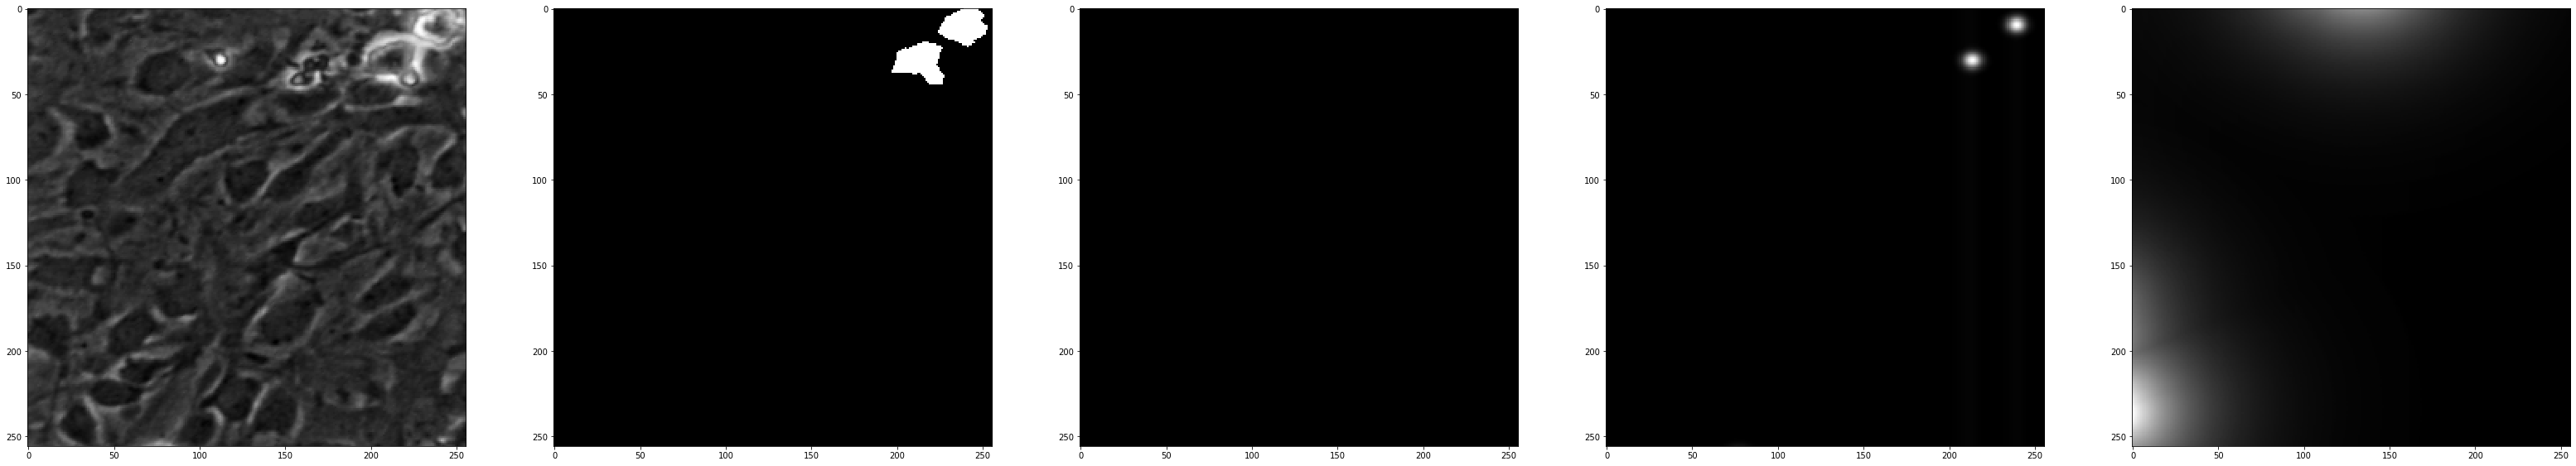

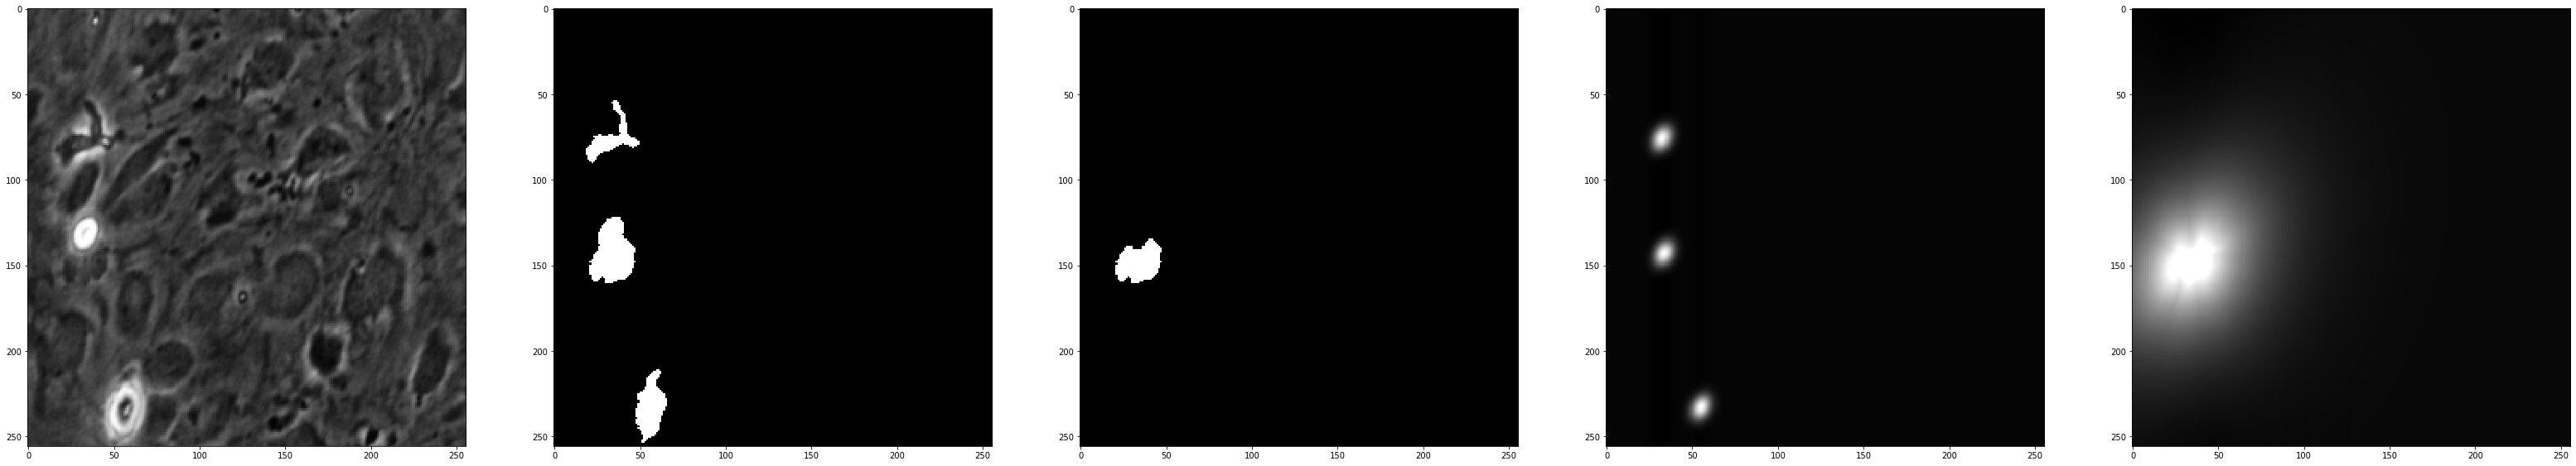

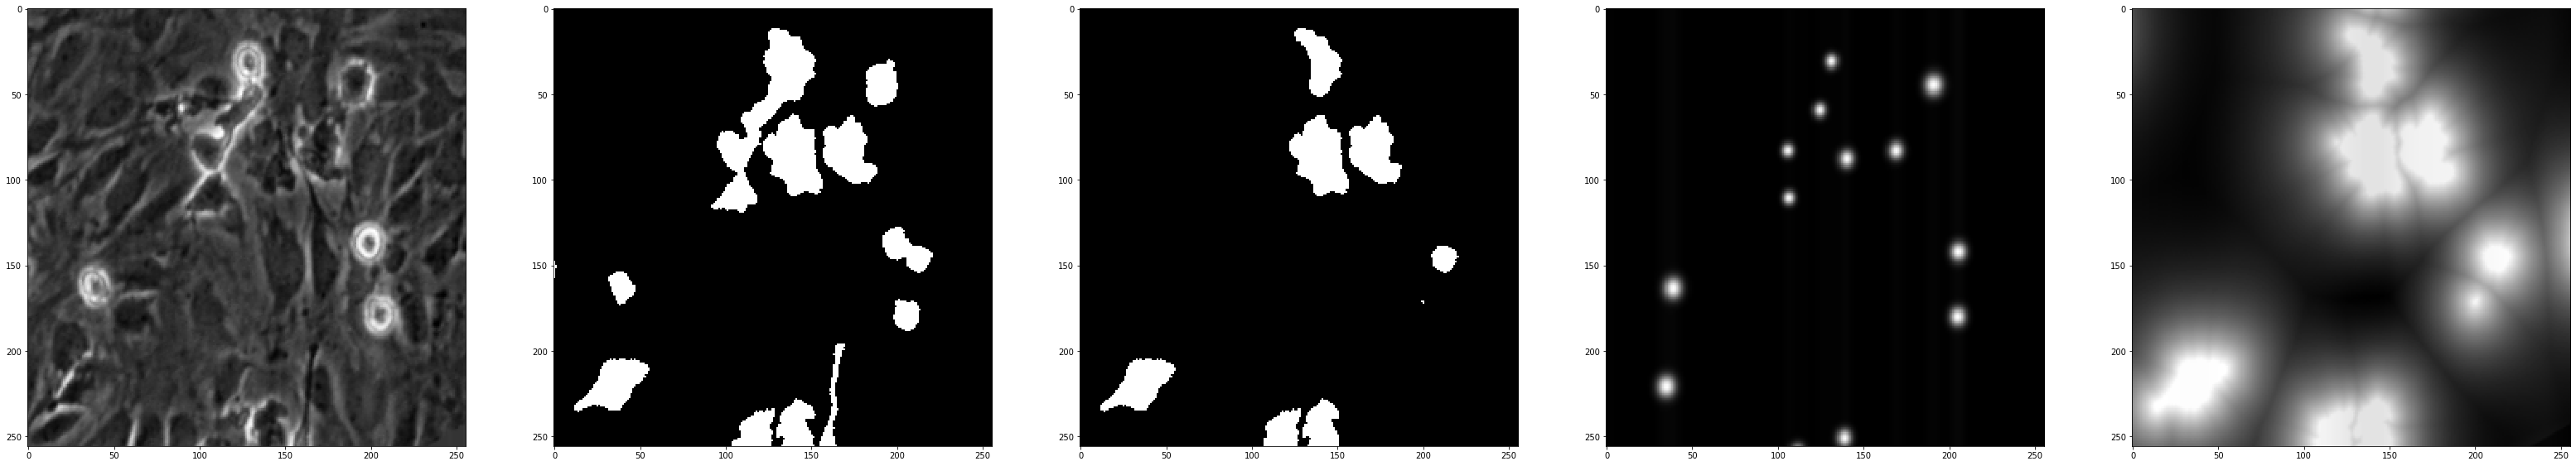

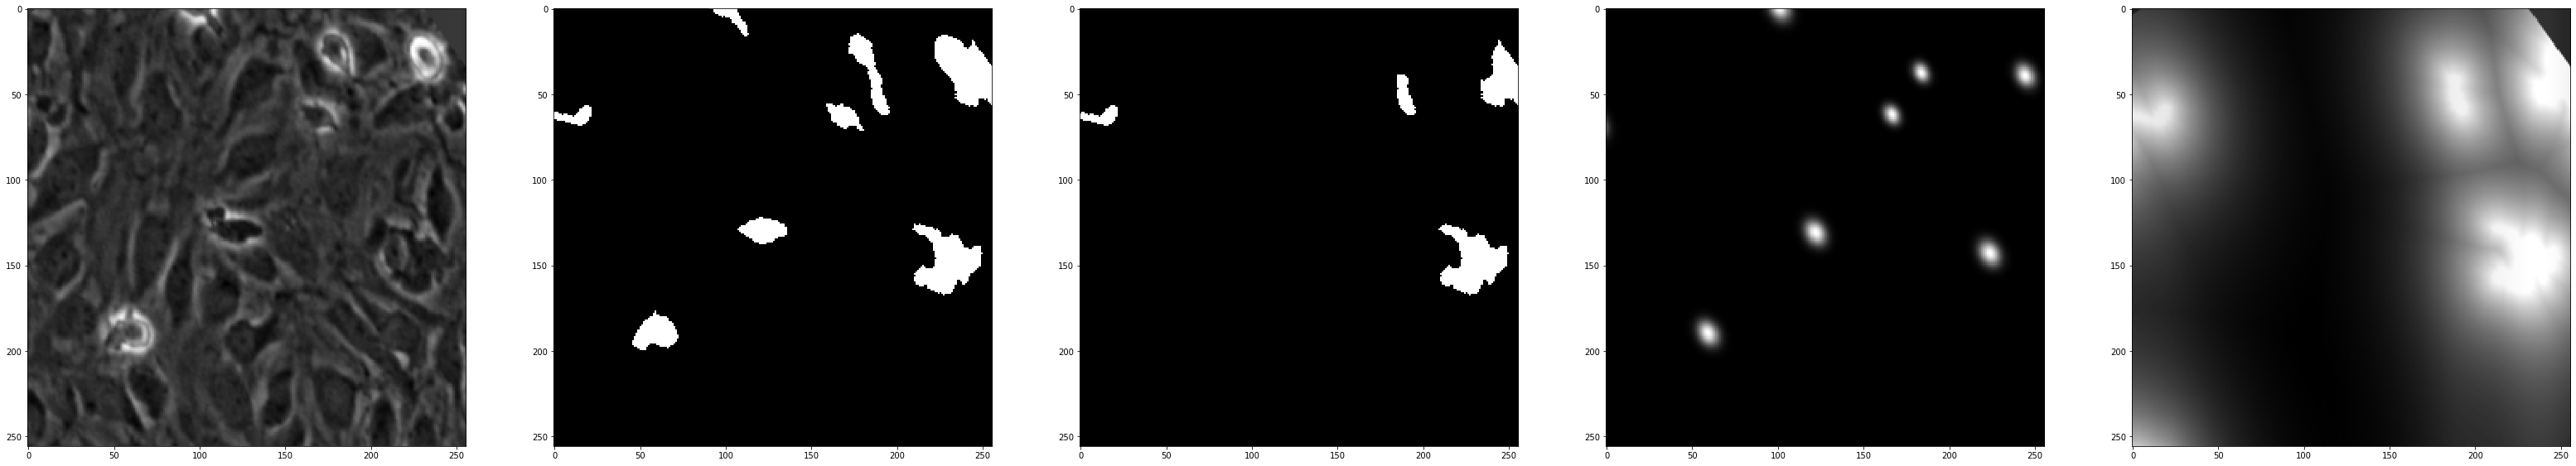

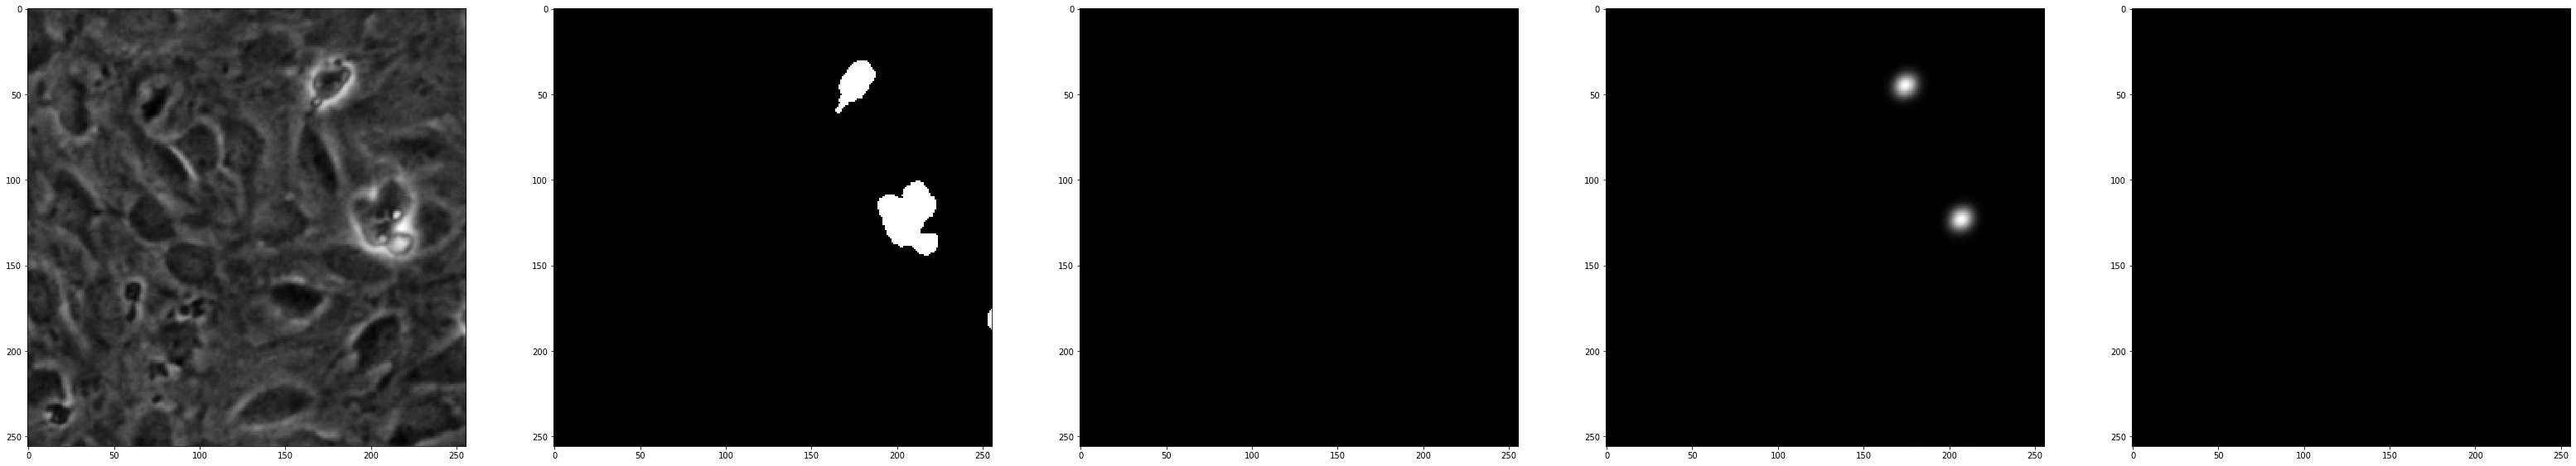

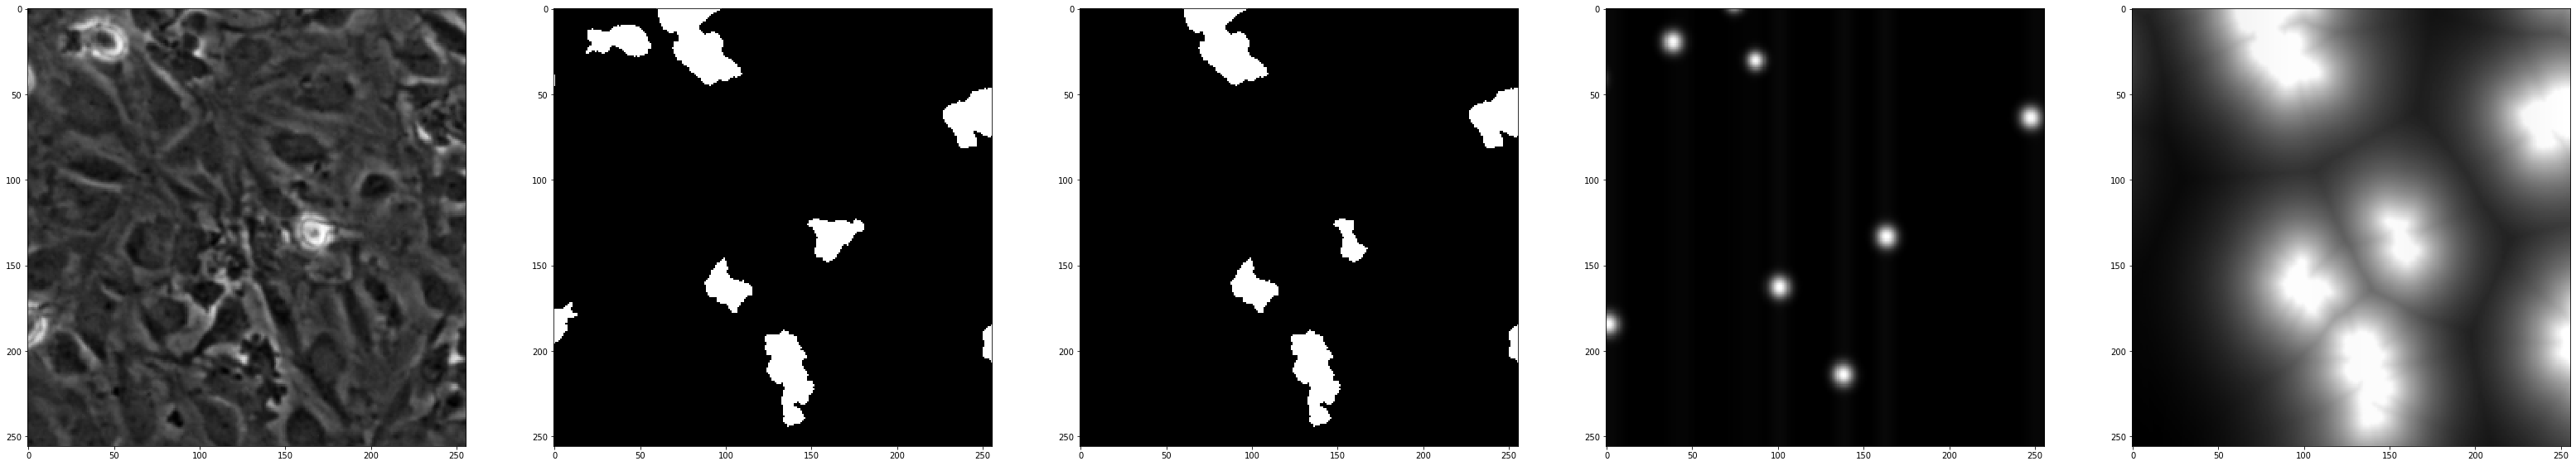

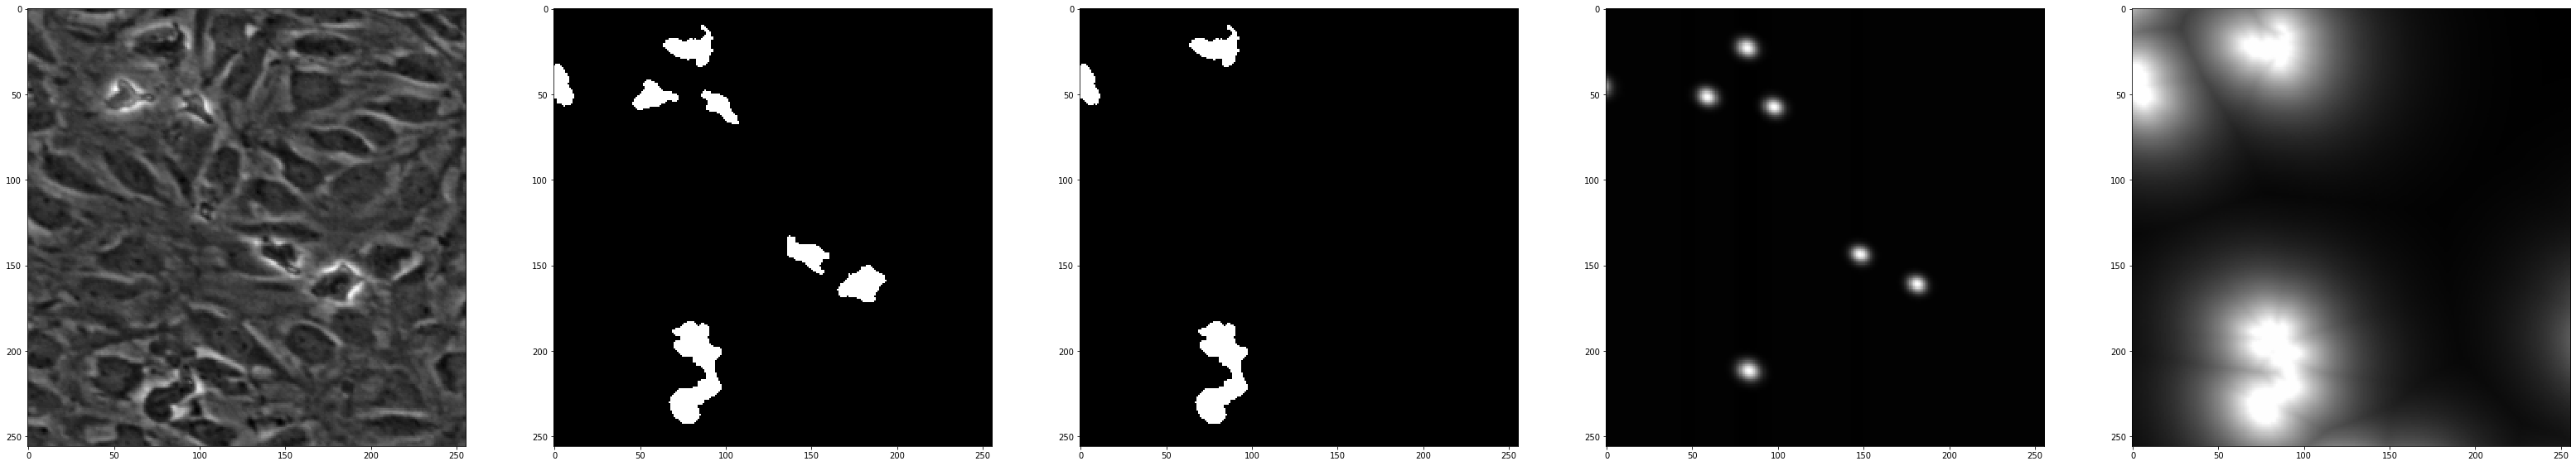

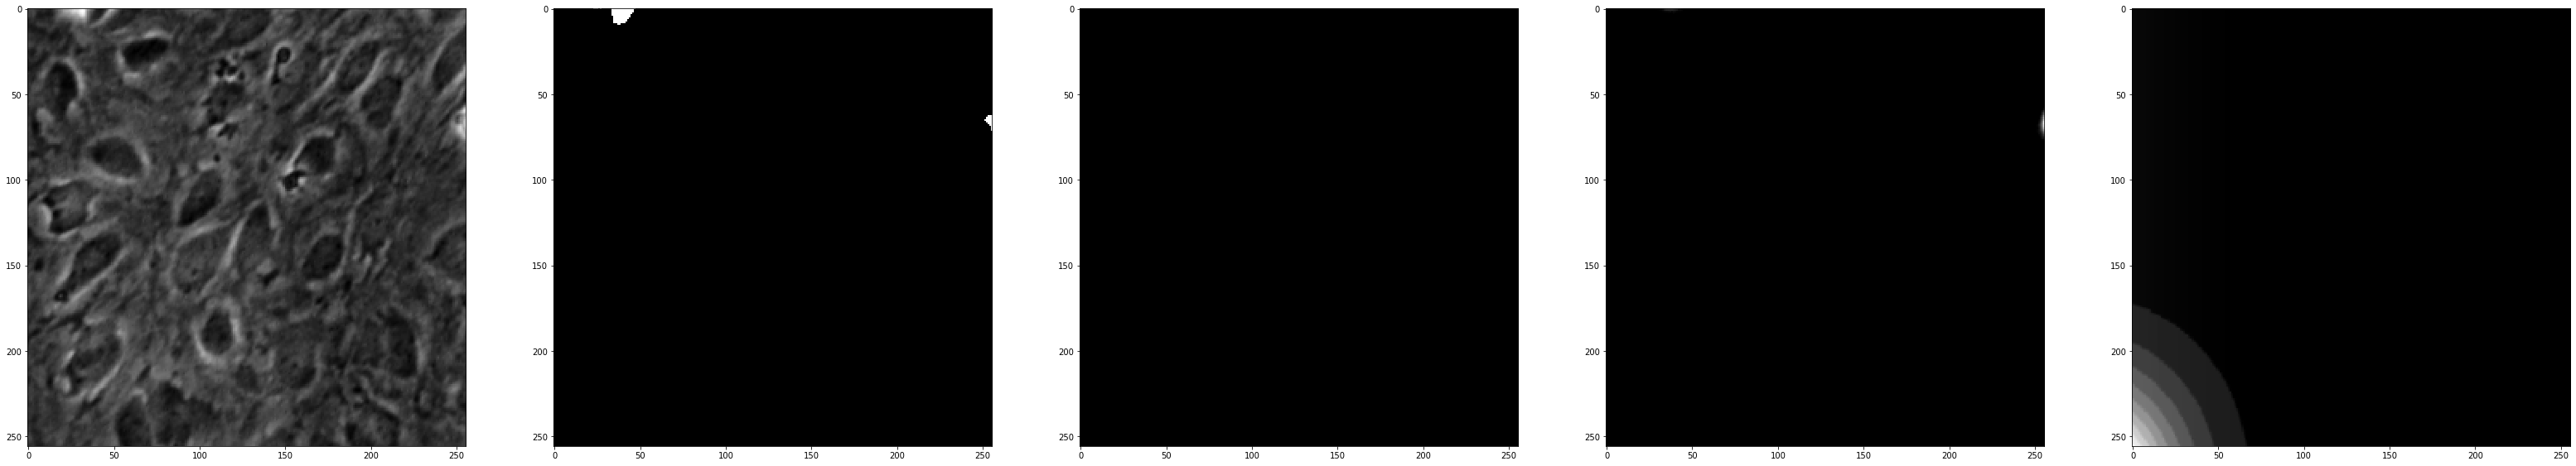

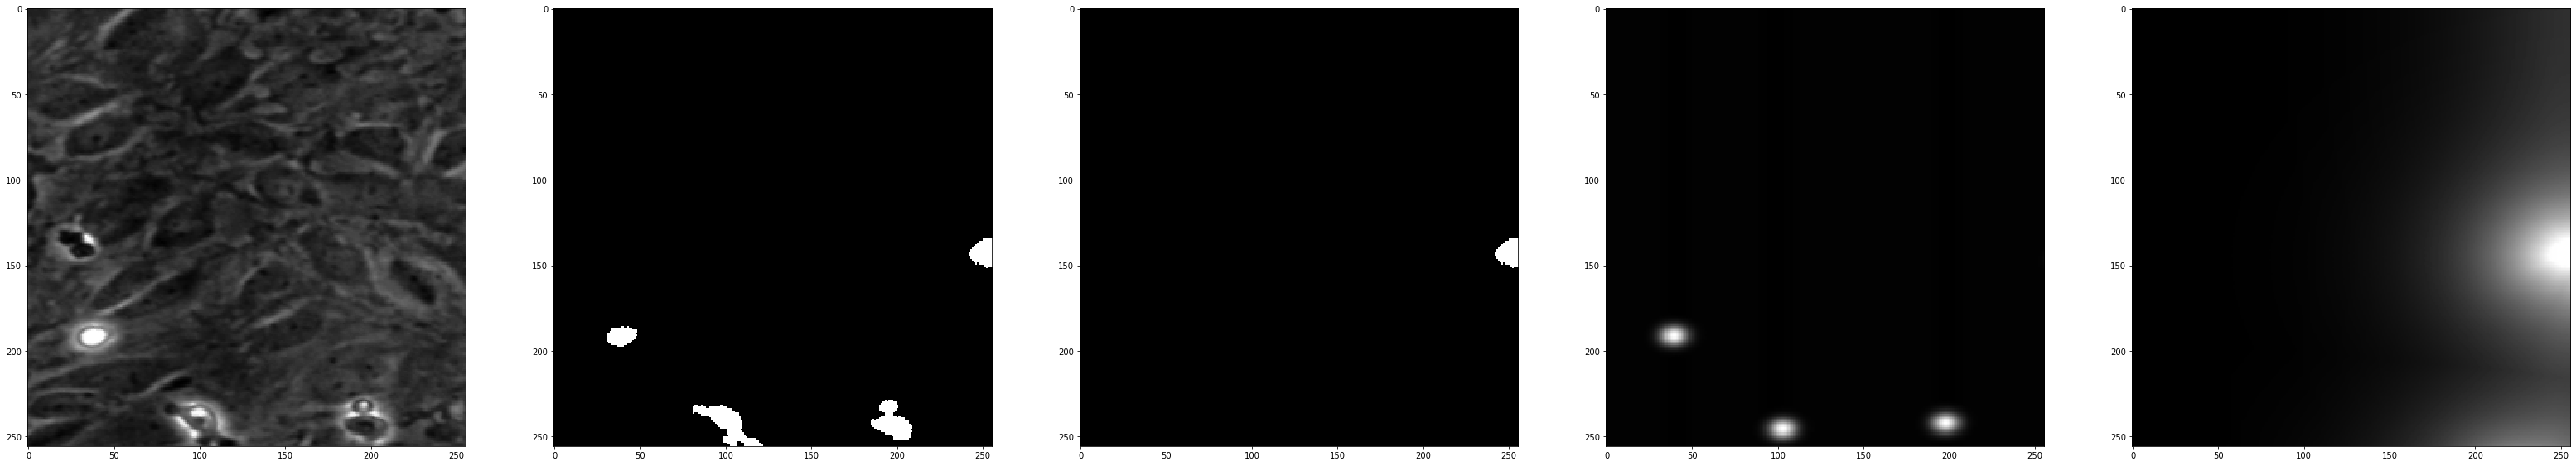

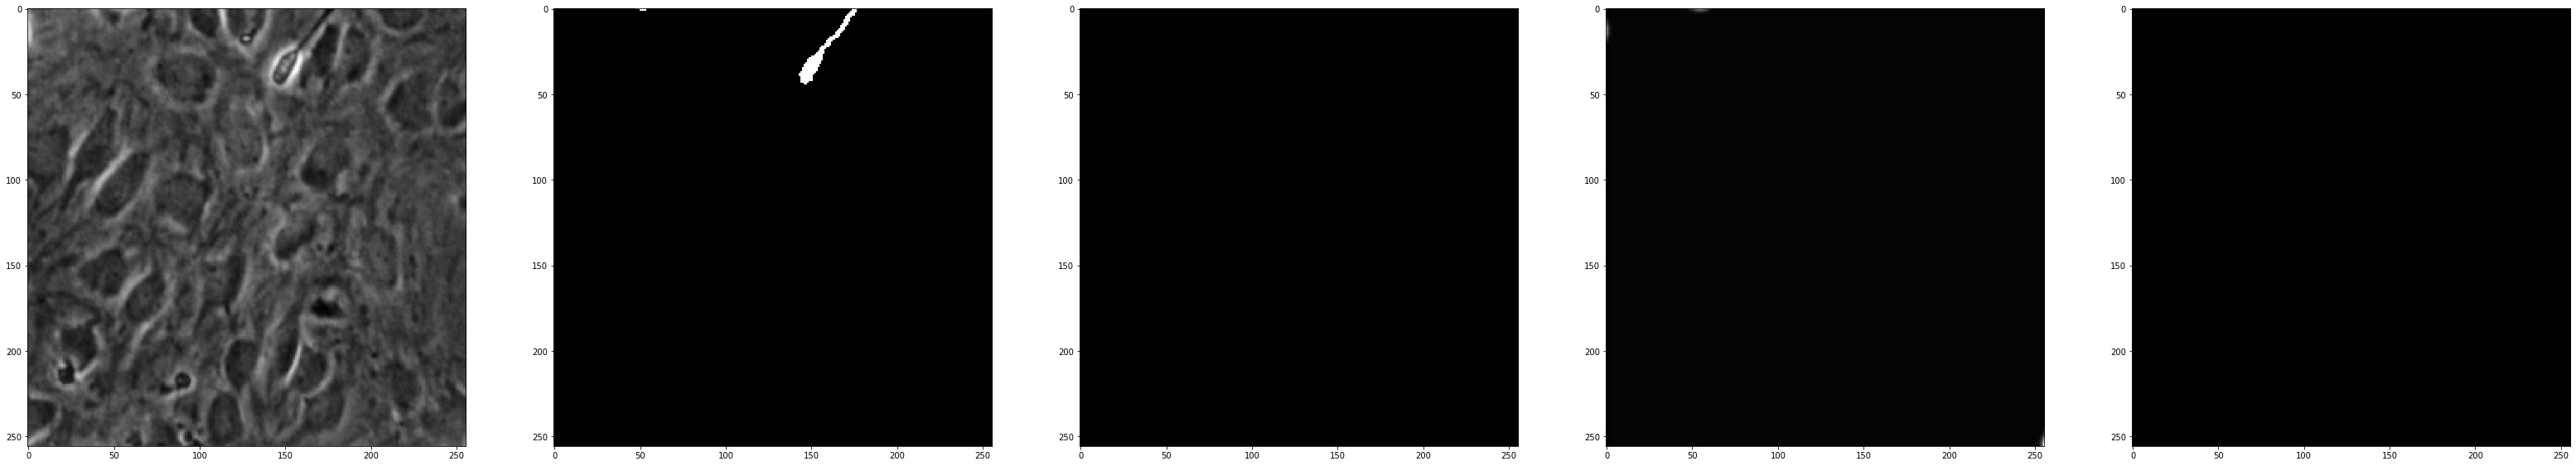

(4, 5, 256, 256) (4, 5, 256, 256) (4, 5, 256, 256) (4, 5, 256, 256) float32 int32 int32 float32
val:


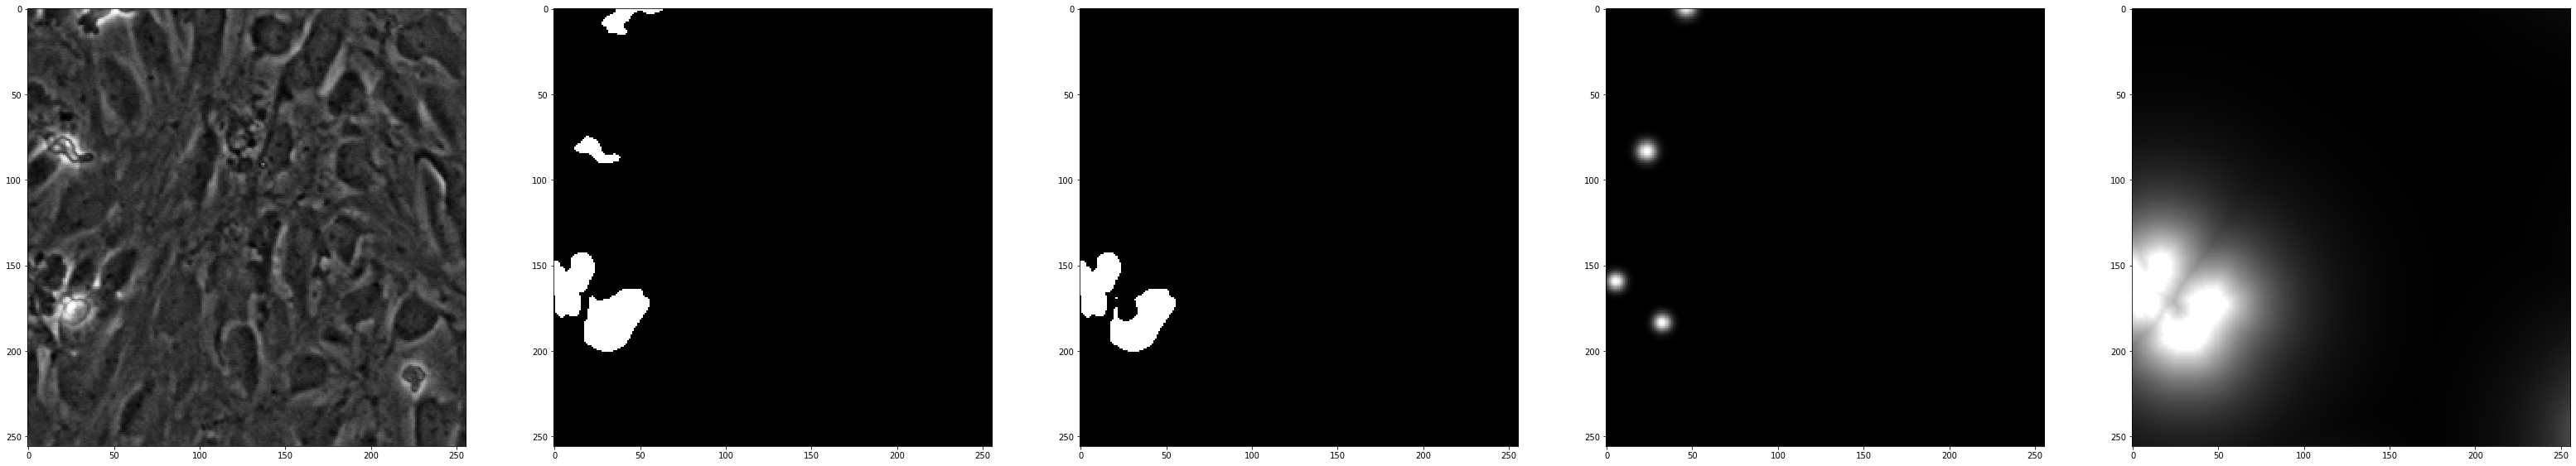

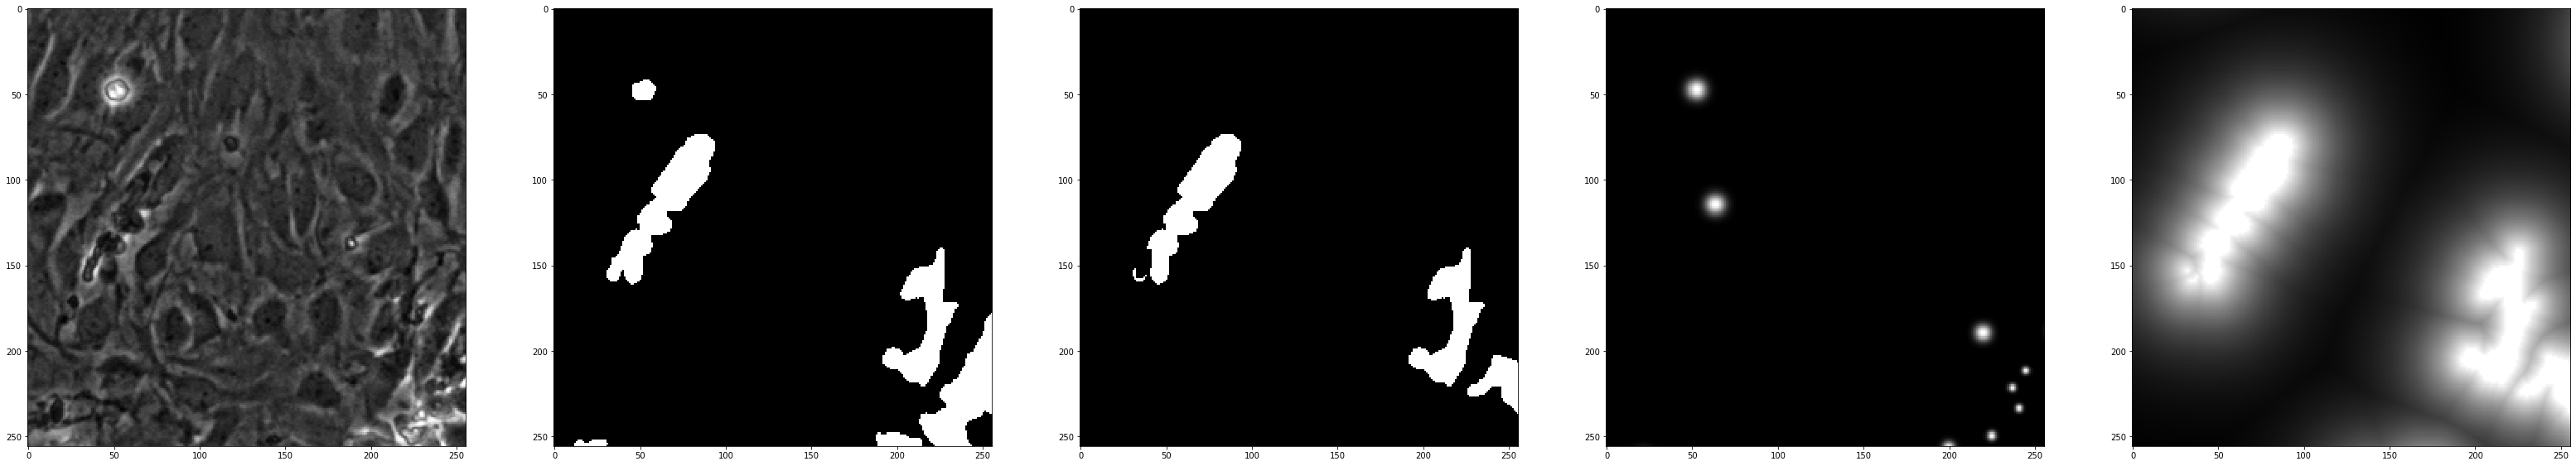

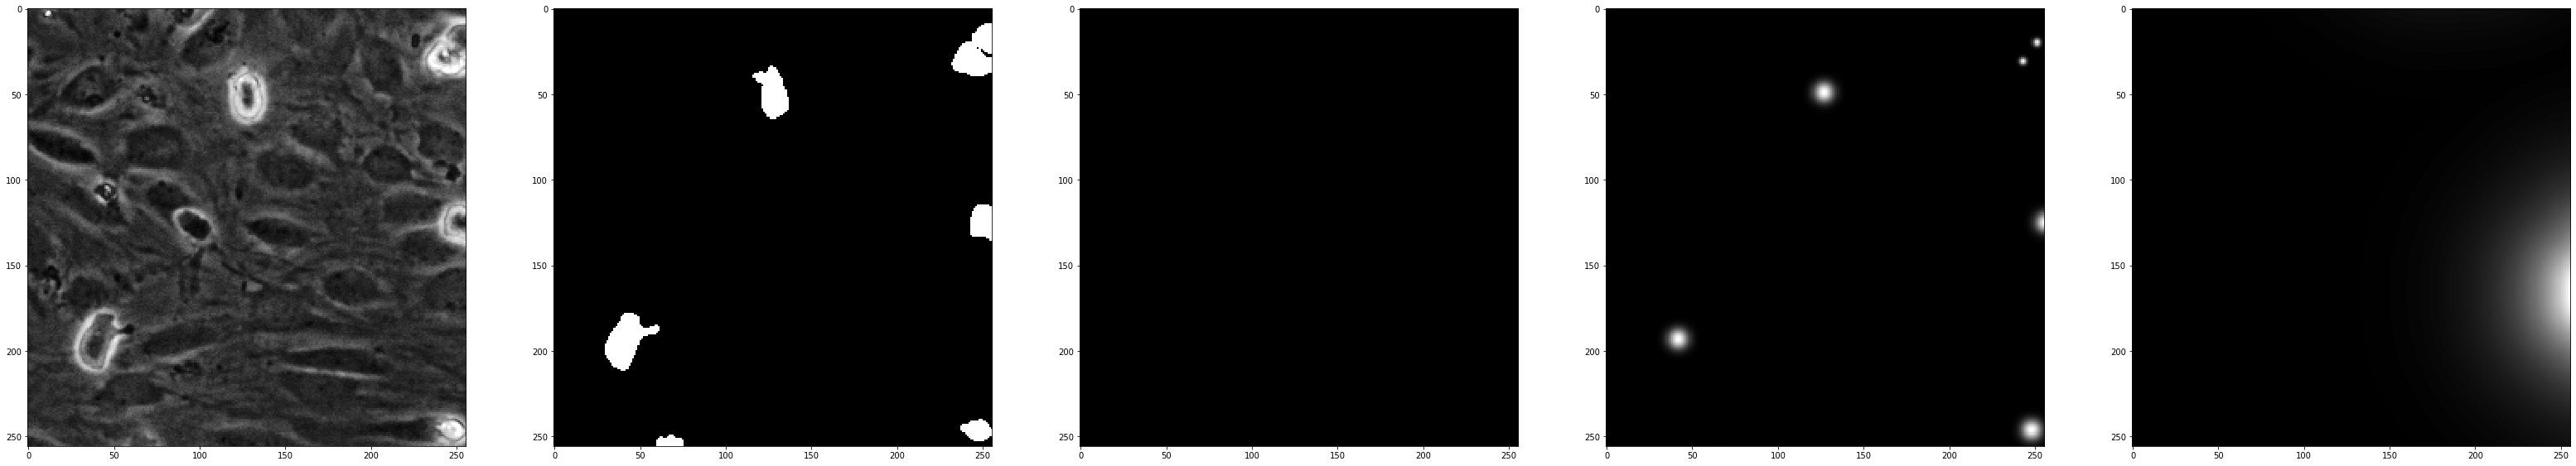

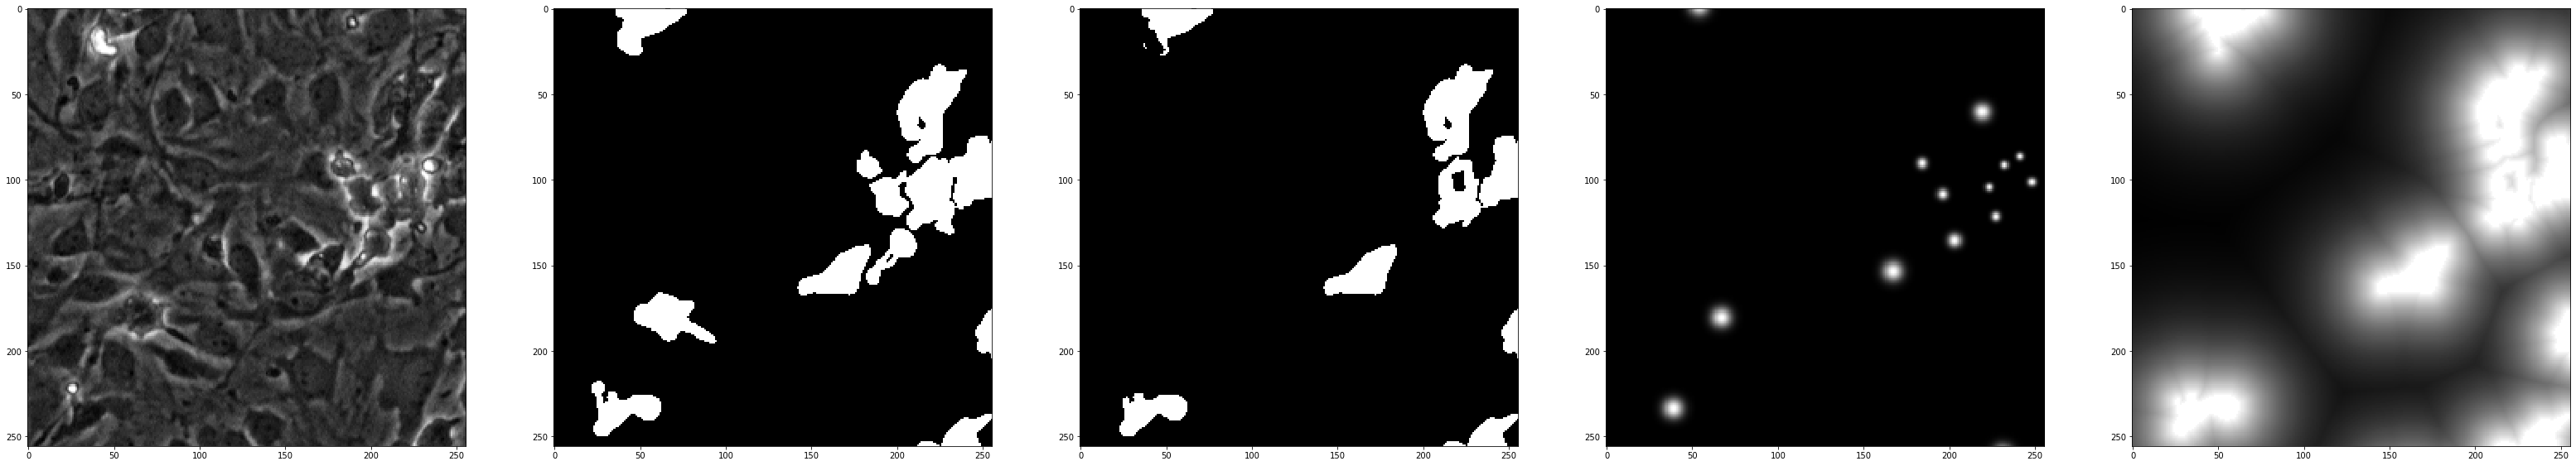

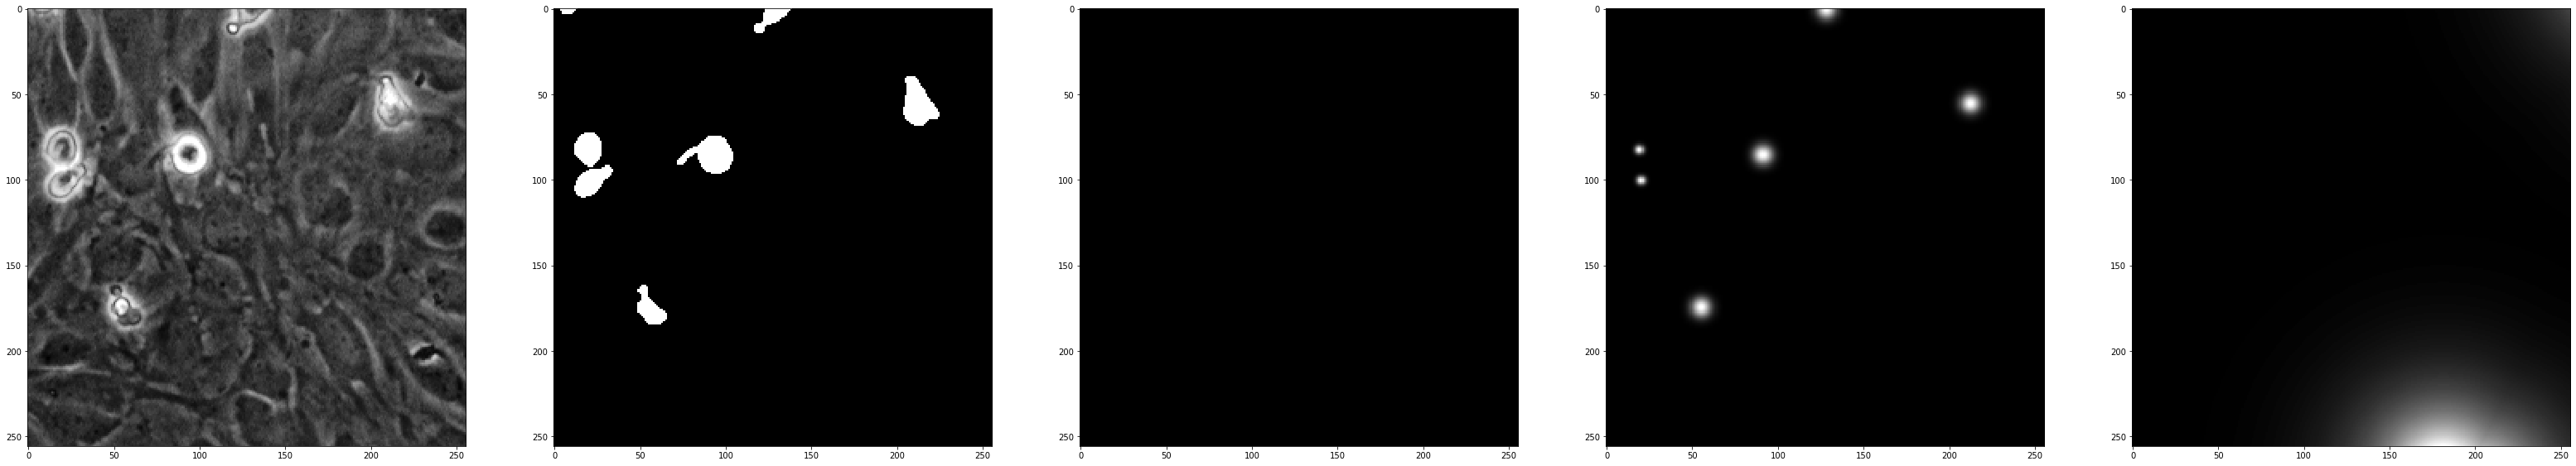

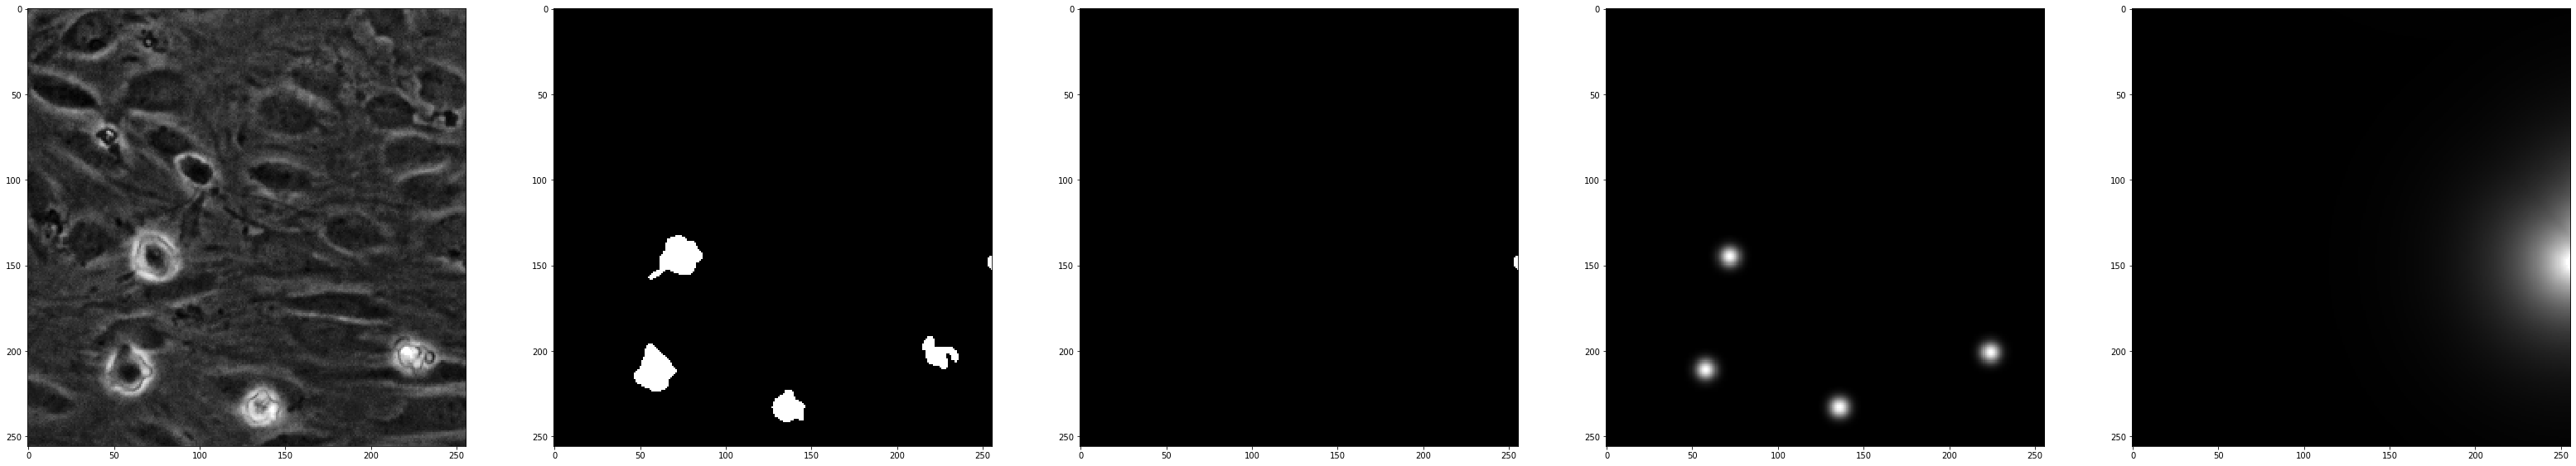

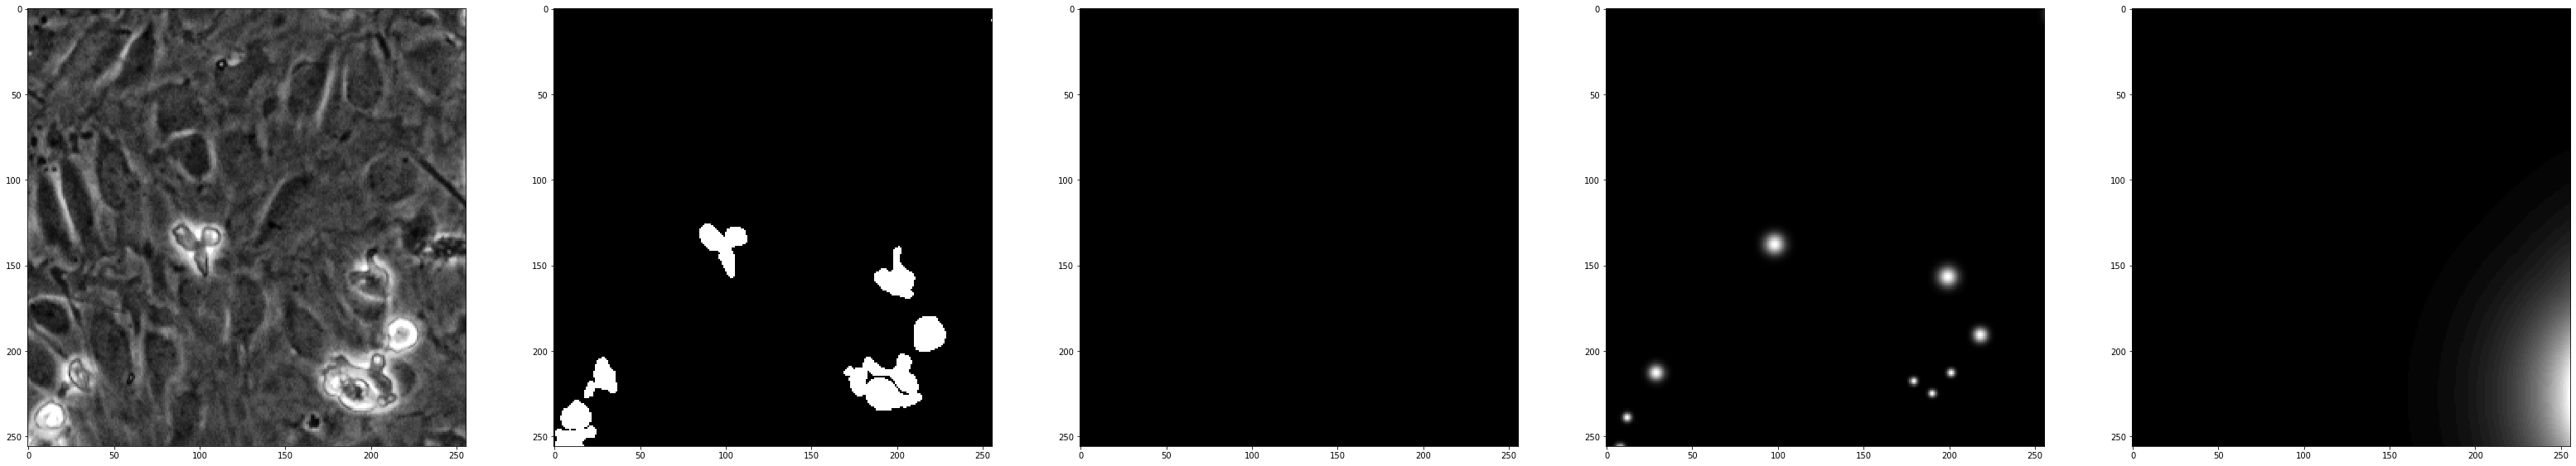

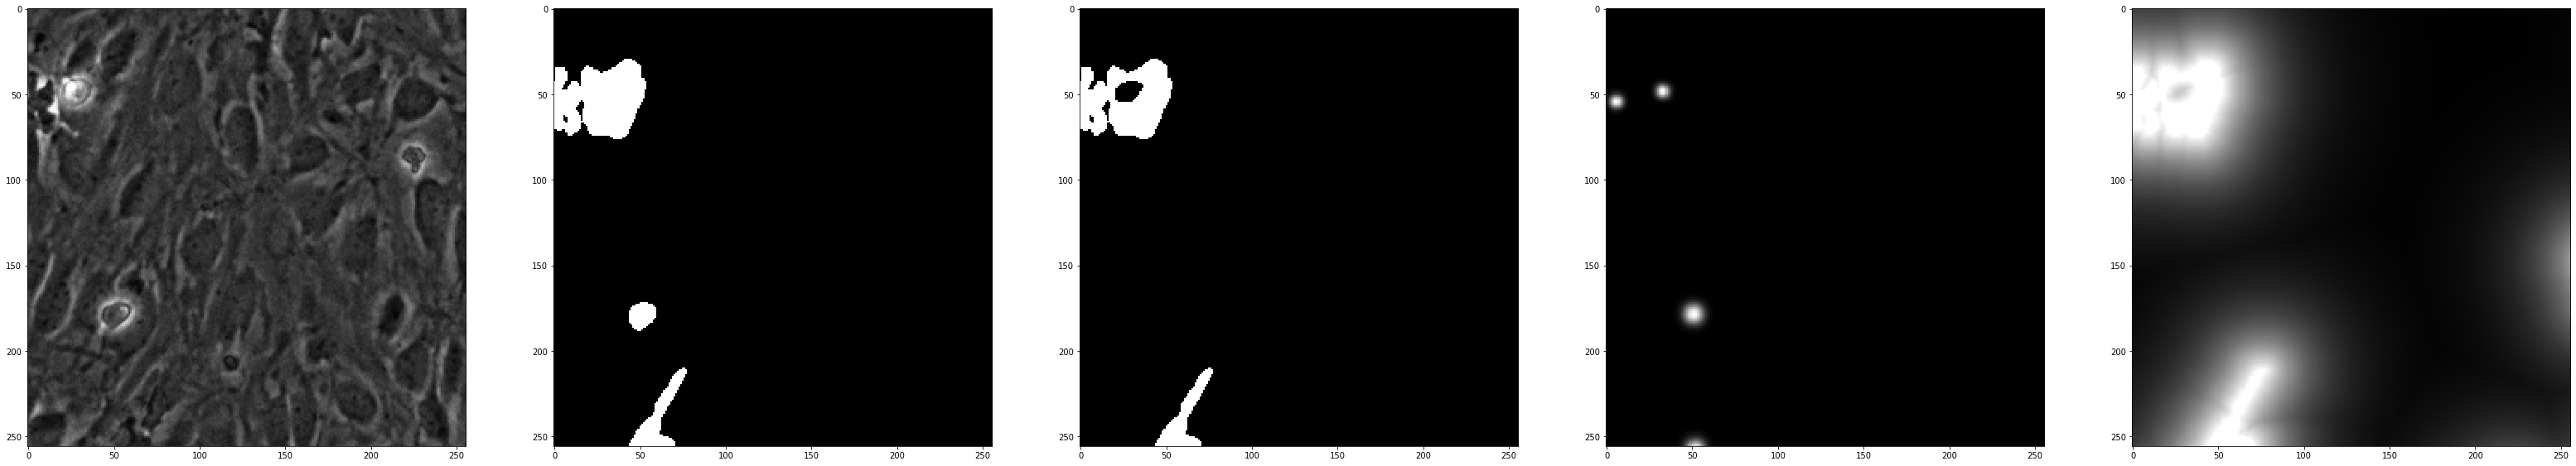

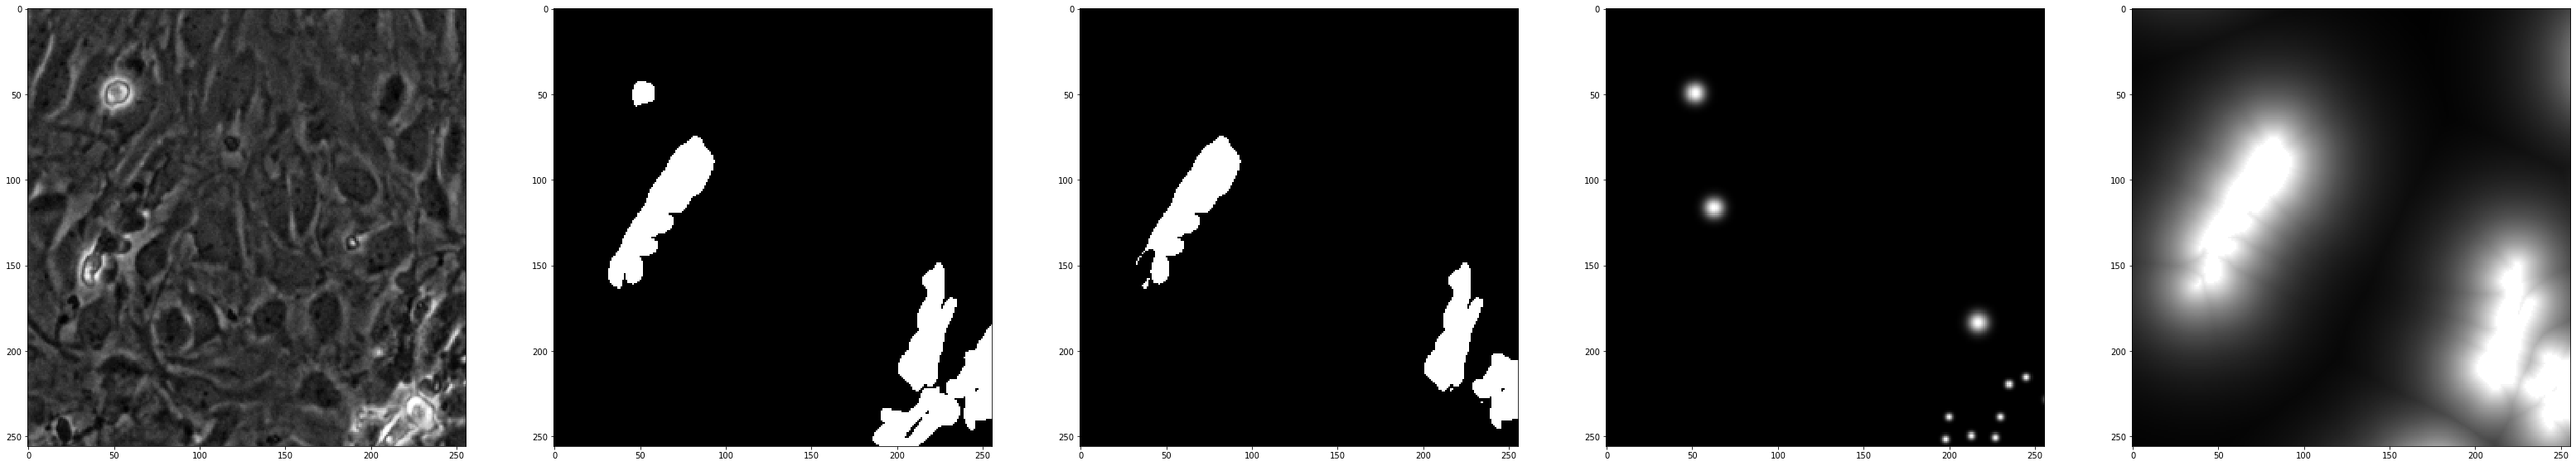

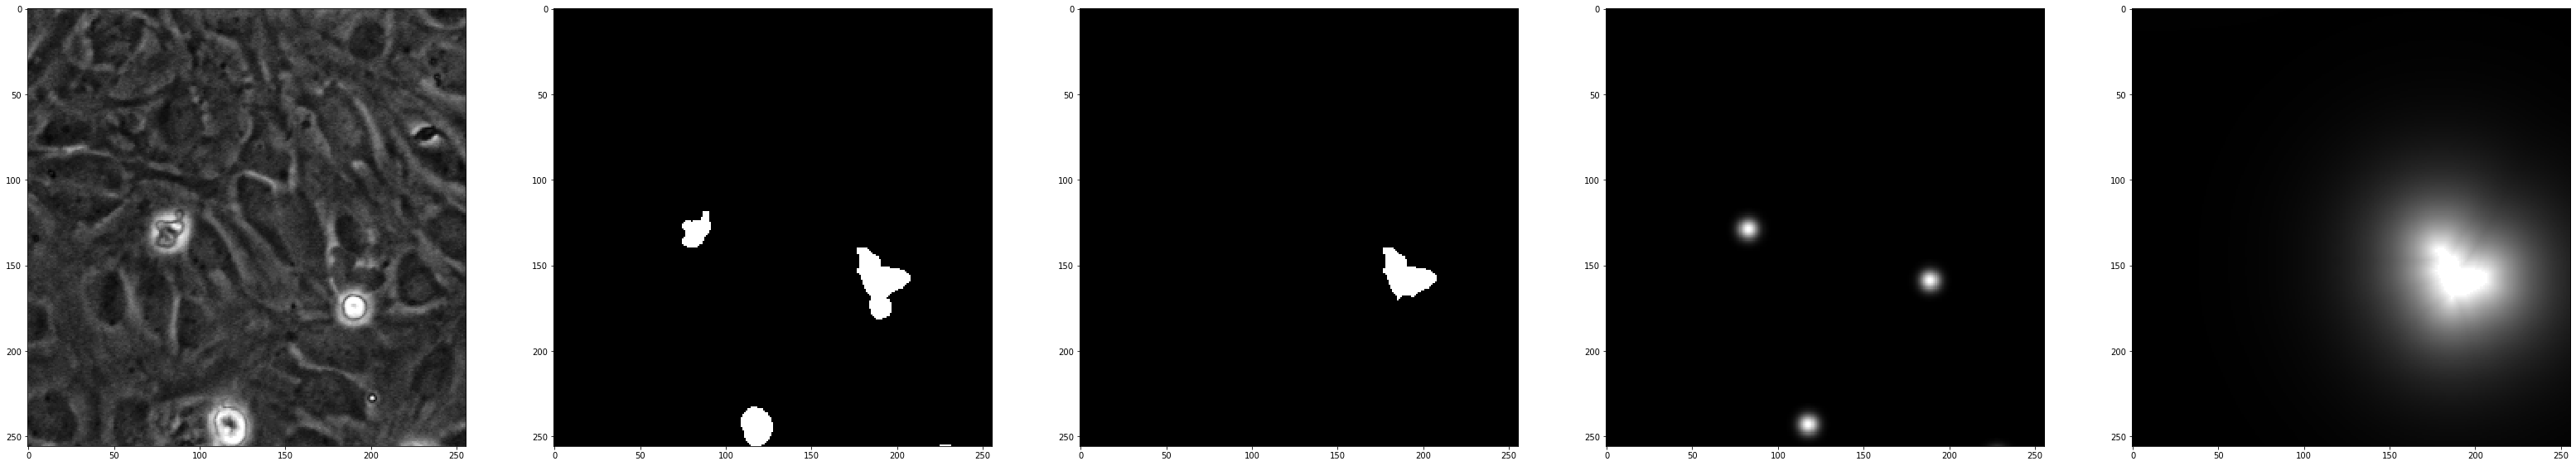

(4, 5, 256, 256) (4, 5, 256, 256) (4, 5, 256, 256) (4, 5, 256, 256) float32 int32 int32 float32


In [5]:
d, v, desc = ds.load_train_val_dataset('data/prepared_datasets/ds_big_all10_ref07/',
                              preproc_devs=('/gpu:0',),
                              minibatch_size=4,
                              queue_len=10,
                              shuffle_output=True,
                              num_proc_threads=8)

with nu.TFSession(d.get_graph()) as sess:
    d.start_queues(sess)
    v.start_queues(sess)
    
    for i in range(10):
        x,y,z,w,r = sess.run(d.minibatch)
        iio.draw_samples((x[0,0], y[0,0], z[0,0], w[0,0], r[0,0]))
    print(x.shape, y.shape, z.shape, w.shape, x.dtype, y.dtype, z.dtype, w.dtype)
    
    print('val:')
    
    for i in range(10):
        x,y,z,w,r = sess.run(v.minibatch)
        iio.draw_samples((x[0,0], y[0,0], z[0,0], w[0,0], r[0,0]))
    print(x.shape, y.shape, z.shape, w.shape, x.dtype, y.dtype, z.dtype, w.dtype)